In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

In [2]:
size = 50000

In [3]:
#Categorical data
x_1 = np.random.normal(40, 10, size = size)
x_2 = np.random.binomial(1,0.65, size = size)
y = np.around(utils.sigmoid(x_1+x_2*20, alpha = 50)).astype(int)
synth_cat = pd.DataFrame({"y": y, "x_1":x_1, "x_2":x_2})
synth_cat_test = synth_cat.iloc[:round(0.3*size),:]
synth_cat_train = synth_cat.iloc[round(0.3*size):,:]

In [4]:
synth_cat_train["y"].sum()

21093

In [5]:
print("Class 1: ",len(synth_cat_train[synth_cat_train["x_2"]==1])/len(synth_cat_train) ,
    "\nClass 2: ", len(synth_cat_train[synth_cat_train["x_2"]==0])/len(synth_cat_train))
temp = synth_cat_train.copy()
temp = utils.impute(utils.data_remover_cat(temp, "x_2", 30), "x_2")
print("Class 1: ",len(temp[temp["x_2"]==1])/len(temp) ,
    "\nClass 2: ", len(temp[temp["x_2"]==0])/len(temp))

Class 1:  0.6521142857142858 
Class 2:  0.3478857142857143
Class 1:  0.7165714285714285 
Class 2:  0.2834285714285714


In [6]:
res = utils.test_bench(synth_cat_train, synth_cat_test, "y", "x_2", "x_2")

100%|██████████| 4/4 [11:16<00:00, 169.00s/it]


In [7]:
try:
    utils.plotting_cf(["log_reg", "rf_cat", "svm", "knn"],["cca", "mice_def", "mean"], res)
except Exception as e:
    print(e)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

In [8]:
def plotting_others(results):
    for missingness, data in results.items():
        if missingness != "mar" and missingness != "mcar":
            continue
        for metric, res in data.items():
            for model, imps in res.items():
                for imputation, vals in imps.items():
                    if len(vals) == 0:
                        continue
                    if isinstance(vals[0], dict):
                        y_0 = np.zeros(len(vals))
                        y_1 = np.zeros(len(vals))

                        for i,dictio in enumerate(vals):
                            y_0[i] = dictio["Y=0"]
                            y_1[i] = dictio["Y=1"]
                        plt.plot(list(results["percentiles"]), list(
                        y_0), label=model+"_"+imputation+"Y=0")
                        plt.plot(list(results["percentiles"]), list(
                        y_1), label=model+"_"+imputation+"Y=1")
                        plt.title(model+"_"+imputation+"_"+metric+"_"+missingness)
                        plt.xlabel("Missingness percent")
                        plt.ylabel(metric)
                        plt.legend()
                        

                    else:
                        plt.plot(list(results["percentiles"]), list(
                            vals), label=model+"_"+imputation)
                        plt.title(model+"_"+imputation+"_"+metric+"_"+missingness)
                        plt.xlabel("Missingness percent")
                        plt.ylabel(metric)
                        plt.legend()
                plt.show()

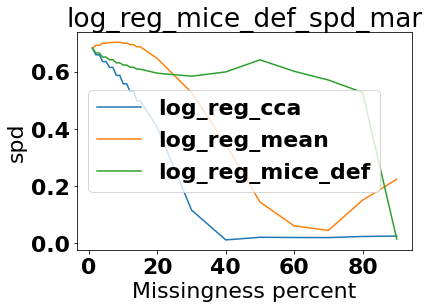

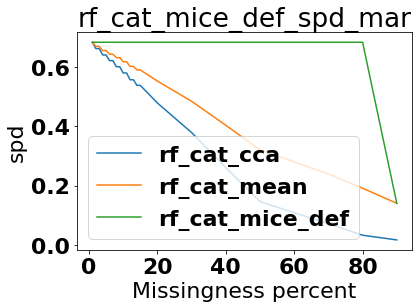

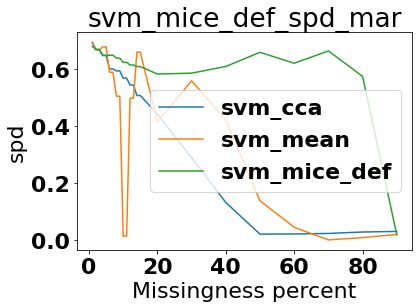

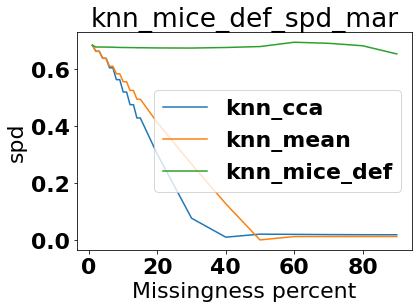

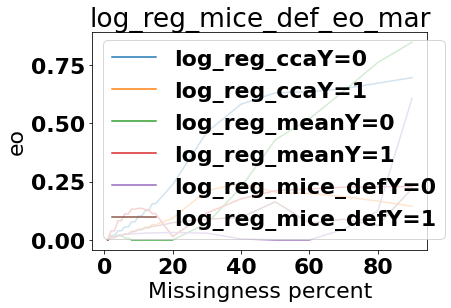

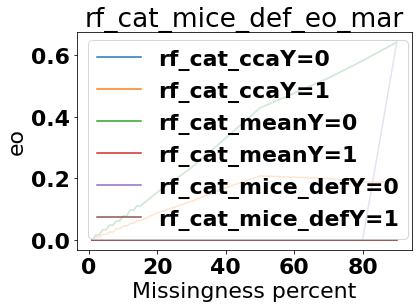

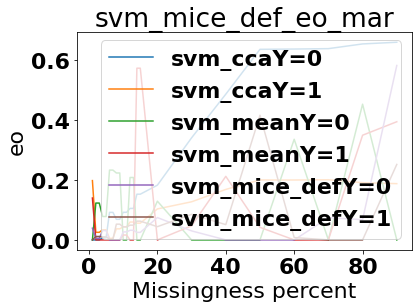

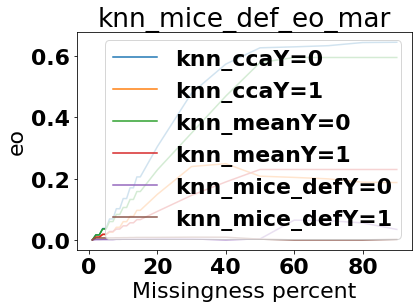

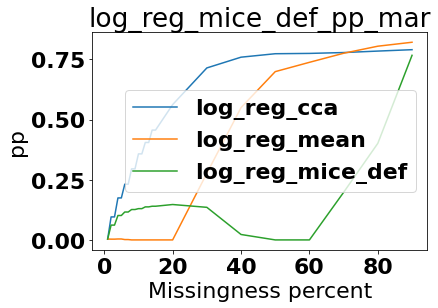

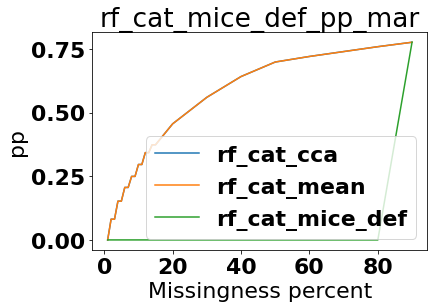

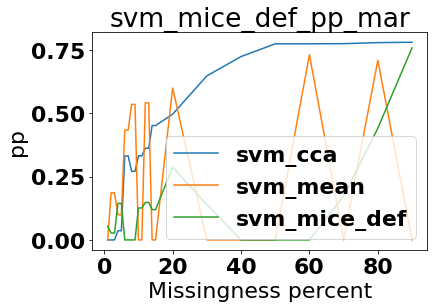

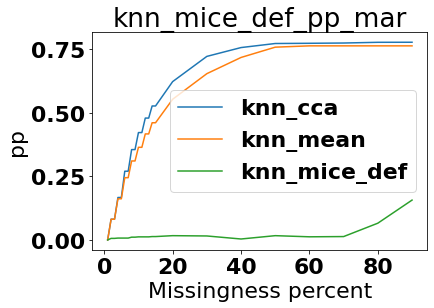

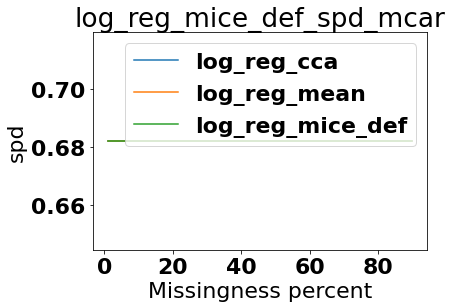

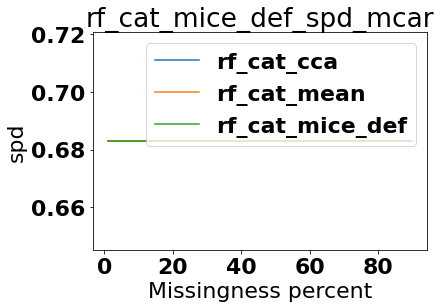

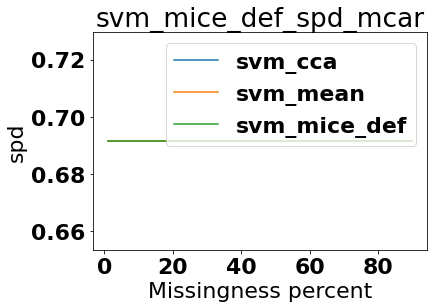

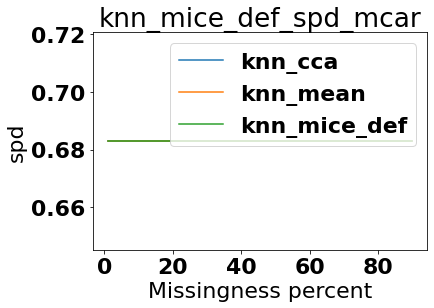

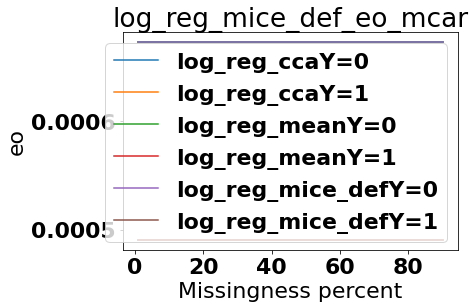

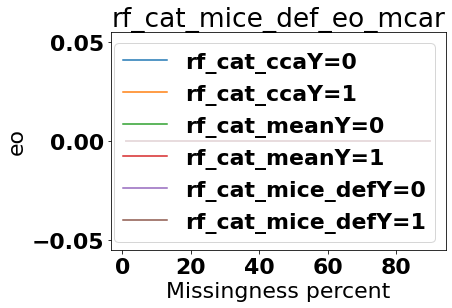

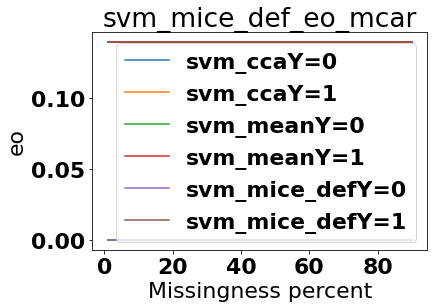

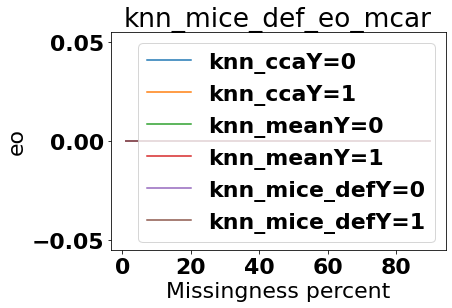

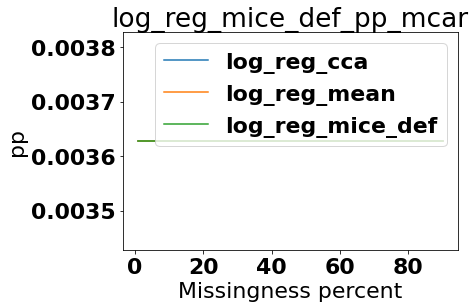

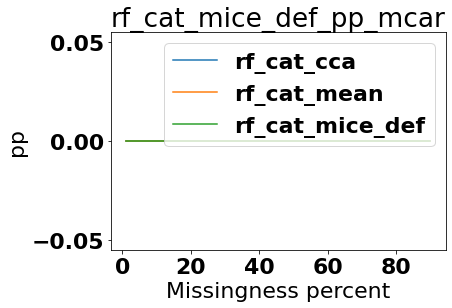

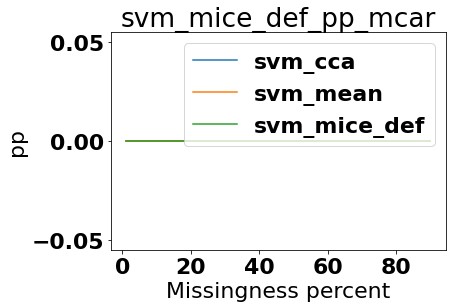

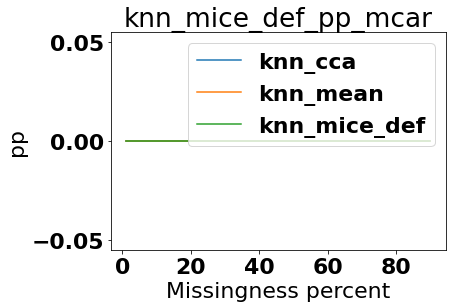

In [9]:
plotting_others(res)